<a href="https://colab.research.google.com/github/OTN-Rajapaksha/Coding-Test-1-Urban-Computer/blob/main/codingtest_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Segment

## 24882 - Oshan Rajapaksha

Coding Test - Congestion Detection using Quad-tree Implementation

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
import seaborn as sns

In [9]:
data = pd.read_csv('/content/Chicago_Traffic_Tracker_-_Historical_Congestion_Estimates_by_Segment_-_2018-2023_20250726.csv')

In [10]:
data.shape


(14058, 22)

In [11]:
df = data.head(10000)

In [12]:
df.head()

,TIME,SEGMENT_ID,SPEED,STREET,DIRECTION,FROM_STREET,TO_STREET,LENGTH,STREET_HEADING,COMMENTS,...,HOUR,DAY_OF_WEEK,MONTH,RECORD_ID,START_LATITUDE,START_LONGITUDE,END_LATITUDE,END_LONGITUDE,START_LOCATION,END_LOCATION
0,03/15/2018 02:10:55 PM,1172,-1,Harlem,SB,Gunnison,Forest Preserve Ave,1.00,N,Outside City Limits,...,14,5,3,1172-201803151910,41.968344,-87.807382,41.953814,-87.807550,POINT (-87.8073823878 41.9683436725),POINT (-87.8075497455 41.9538138239)
1,03/15/2018 02:10:55 PM,1303,23,Balbo,WB,LakeShore Dr,Michigan,0.52,E,NaN,...,14,5,3,1303-201803151910,41.873356,-87.617312,41.873192,-87.627565,POINT (-87.617312 41.873356),POINT (-87.627565 41.873192)
2,03/15/2018 02:10:55 PM,1220,17,Halsted,NB,Roosevelt,Harrison,0.50,S,NaN,...,14,5,3,1220-201803151910,41.867152,-87.646729,41.874338,-87.646935,POINT (-87.646729 41.867152),POINT (-87.646935 41.874338)
3,03/15/2018 02:10:55 PM,1182,14,Broadway,NB,Hollywood,Devon,0.88,N,NaN,...,14,5,3,1182-201803151910,41.985461,-87.659942,41.998208,-87.660173,POINT (-87.6599416534 41.9854613518),POINT (-87.6601728465 41.9982075605)
4,03/15/2018 02:10:55 PM,1216,24,Halsted,NB,31st,Archer,0.63,S,NaN,...,14,5,3,1216-201803151910,41.838046,-87.646086,41.847196,-87.646297,POINT (-87.646086 41.838046),POINT (-87.646297 41.847196)


In [13]:
df.shape

(10000, 22)

In [14]:
df.columns

Index(['TIME', 'SEGMENT_ID', 'SPEED', 'STREET', 'DIRECTION', 'FROM_STREET',
       'TO_STREET', 'LENGTH', 'STREET_HEADING', 'COMMENTS', 'BUS_COUNT',
       'MESSAGE_COUNT', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'RECORD_ID',
       'START_LATITUDE', 'START_LONGITUDE', 'END_LATITUDE', 'END_LONGITUDE',
       'START_LOCATION', 'END_LOCATION'],
      dtype='object')

In [15]:
df.columns = df.columns.str.strip()
print("Cleaned column names:")
print(df.columns.tolist())

Cleaned column names:
['TIME', 'SEGMENT_ID', 'SPEED', 'STREET', 'DIRECTION', 'FROM_STREET', 'TO_STREET', 'LENGTH', 'STREET_HEADING', 'COMMENTS', 'BUS_COUNT', 'MESSAGE_COUNT', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'RECORD_ID', 'START_LATITUDE', 'START_LONGITUDE', 'END_LATITUDE', 'END_LONGITUDE', 'START_LOCATION', 'END_LOCATION']


In [16]:
df = data[["START_LATITUDE", "END_LATITUDE", "START_LONGITUDE", "END_LONGITUDE"]].copy()
df["mid_lat"] = (df["START_LATITUDE"] + df["END_LATITUDE"]) / 2
df["mid_lon"] = (df["START_LONGITUDE"] + df["END_LONGITUDE"]) / 2


In [17]:
df = df.dropna(subset=['mid_lat','mid_lon'])

In [18]:
print(f"Total traffic segments: {len(df)}")
print(f"Latitude range: {df['mid_lat'].min():.4f} to {df['mid_lat'].max():.4f}")
print(f"Longitude range: {df['mid_lon'].min():.4f} to {df['mid_lon'].max():.4f}")

Total traffic segments: 14058
Latitude range: 41.6594 to 42.0121
Longitude range: -87.8368 to -87.5351


## 2 Quad-tree Implementation

Implementing Point, Rectangle, and QuadTree classes

In [19]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __repr__(self):
        return f"Point(x={self.x}, y={self.y})"

# Create Point objects from our data
points = []
for i in range(len(df)):
    point = Point(df.iloc[i]['mid_lon'], df.iloc[i]['mid_lat'])
    points.append(point)
print(f"Created {len(points)} point objects")

Created 14058 point objects


In [20]:
class Rectangle:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height

    def contains(self, point):
        return (self.x <= point.x <= self.x + self.width and
                self.y <= point.y <= self.y + self.height)

    def __repr__(self):
        return f"Rectangle(x={self.x}, y={self.y}, w={self.width}, h={self.height})"

# Test the Rectangle class
test_rect = Rectangle(-87.8, 41.8, 0.2, 0.2)
print("Rectangle class created successfully")

Rectangle class created successfully


In [21]:
class QuadTree:
    def __init__(self, boundary):
        self.boundary = boundary
        self.points = []
        self.capacity = 4  # Maximum 4 points before splitting
        self.divided = False
        # Children nodes
        self.northwest = None
        self.northeast = None
        self.southwest = None
        self.southeast = None

    def insert_point(self, point):
        # Check if point is in this boundary
        if not self.boundary.contains(point):
            return False
        # If we have space, add the point
        if len(self.points) < self.capacity:
            self.points.append(point)
            return True
        # If not divided yet, divide now
        if not self.divided:
            self.divide()
        # Try to insert in children
        if self.northwest.insert_point(point):
            return True
        if self.northeast.insert_point(point):
            return True
        if self.southwest.insert_point(point):
            return True
        if self.southeast.insert_point(point):
            return True
        return False

    def divide(self):
        x = self.boundary.x
        y = self.boundary.y
        w = self.boundary.width / 2
        h = self.boundary.height / 2
        # Create 4 children
        nw = Rectangle(x,     y + h, w, h)
        ne = Rectangle(x + w, y + h, w, h)
        sw = Rectangle(x,     y,     w, h)
        se = Rectangle(x + w, y,     w, h)
        self.northwest = QuadTree(nw)
        self.northeast = QuadTree(ne)
        self.southwest = QuadTree(sw)
        self.southeast = QuadTree(se)
        self.divided = True
        print("QuadTree class created successfully")

In [22]:
min_lon = df['mid_lon'].min()
max_lon = df['mid_lon'].max()
min_lat = df['mid_lat'].min()
max_lat = df['mid_lat'].max()
# Add some padding
padding = 0.01
boundary = Rectangle(min_lon - padding, min_lat - padding,
(max_lon - min_lon) + 2*padding,
(max_lat - min_lat) + 2*padding)
print(f"Main boundary: ({boundary.x:.4f}, {boundary.y:.4f}) "
f"width={boundary.width:.4f}, height={boundary.height:.4f}")

Main boundary: (-87.8468, 41.6494) width=0.3217, height=0.3727


In [23]:
qtree = QuadTree(boundary)
inserted_count = 0

for point in points:
    if qtree.insert_point(point):
        inserted_count += 1

print(f"Inserted {inserted_count} out of {len(points)} points")


QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created succe

In [24]:
min_lon = df['mid_lon'].min()
max_lon = df['mid_lon'].max()
min_lat = df['mid_lat'].min()
max_lat = df['mid_lat'].max()

# Add some padding

padding = 0.01
boundary = Rectangle(min_lon - padding, min_lat - padding,
 (max_lon - min_lon) + 2*padding,
 (max_lat - min_lat) + 2*padding)
print(f"Main boundary: ({boundary.x:.4f}, {boundary.y:.4f}) "
f"width={boundary.width:.4f}, height={boundary.height:.4f}")

Main boundary: (-87.8468, 41.6494) width=0.3217, height=0.3727


In [26]:
qtree = QuadTree(boundary)
inserted_count = 0
for point in points:
    if qtree.insert_point(point):
        inserted_count += 1
print(f"Inserted {inserted_count} out of {len(points)} points")

QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created successfully
QuadTree class created succe

## 3 Congestion Detection

In [27]:
def find_congested_zones(qtree, threshold=4):
    congested = []
    # If this node is not divided (it's a leaf)
    if not qtree.divided:
        if len(qtree.points) >= threshold:  # Congested if >= threshold points
            congested.append(qtree)
    else:
        # Check all children
        if qtree.northwest:
            congested.extend(find_congested_zones(qtree.northwest, threshold))
        if qtree.northeast:
            congested.extend(find_congested_zones(qtree.northeast, threshold))
        if qtree.southwest:
            congested.extend(find_congested_zones(qtree.southwest, threshold))
        if qtree.southeast:
            congested.extend(find_congested_zones(qtree.southeast, threshold))
    return congested


# Example usage (make sure you already created and filled qtree!)
congested_zones = find_congested_zones(qtree, threshold=4)
print(f"Found {len(congested_zones)} congested zones")


Found 322 congested zones


In [29]:
print("CONGESTED ZONES DETAILS:")
for i, zone in enumerate(congested_zones):
    b = zone.boundary
    print(f"Zone {i+1}:")
    print(f" Location: ({b.x:.4f}, {b.y:.4f}) to ({b.x+b.width:.4f}, {b.y+b.height:.4f})")
    print(f" Number of traffic segments: {len(zone.points)}")
    print(f" Area: {b.width*b.height:.8f} square degrees")
    print()

CONGESTED ZONES DETAILS:
Zone 1:
 Location: (-87.8072, 41.9861) to (-87.8069, 41.9865)
 Number of traffic segments: 4
 Area: 0.00000011 square degrees

Zone 2:
 Location: (-87.8069, 41.9861) to (-87.8066, 41.9865)
 Number of traffic segments: 4
 Area: 0.00000011 square degrees

Zone 3:
 Location: (-87.8069, 41.9788) to (-87.8066, 41.9792)
 Number of traffic segments: 4
 Area: 0.00000011 square degrees

Zone 4:
 Location: (-87.7953, 42.0039) to (-87.7946, 42.0047)
 Number of traffic segments: 4
 Area: 0.00000046 square degrees

Zone 5:
 Location: (-87.7946, 42.0039) to (-87.7940, 42.0047)
 Number of traffic segments: 4
 Area: 0.00000046 square degrees

Zone 6:
 Location: (-87.7814, 42.0105) to (-87.7789, 42.0134)
 Number of traffic segments: 4
 Area: 0.00000732 square degrees

Zone 7:
 Location: (-87.7865, 42.0076) to (-87.7840, 42.0105)
 Number of traffic segments: 4
 Area: 0.00000732 square degrees

Zone 8:
 Location: (-87.7852, 41.9937) to (-87.7846, 41.9945)
 Number of traffic segme

In [31]:
def get_all_boundaries(qtree):
    boundaries = [qtree.boundary]
    if qtree.divided:
        boundaries.extend(get_all_boundaries(qtree.northwest))
        boundaries.extend(get_all_boundaries(qtree.northeast))
        boundaries.extend(get_all_boundaries(qtree.southwest))
        boundaries.extend(get_all_boundaries(qtree.southeast))
    return boundaries


# Example usage (make sure qtree exists and has points inserted)
all_boundaries = get_all_boundaries(qtree)
print(f"Total QuadTree nodes: {len(all_boundaries)}")


Total QuadTree nodes: 11337


/tmp/ipython-input-51534205.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


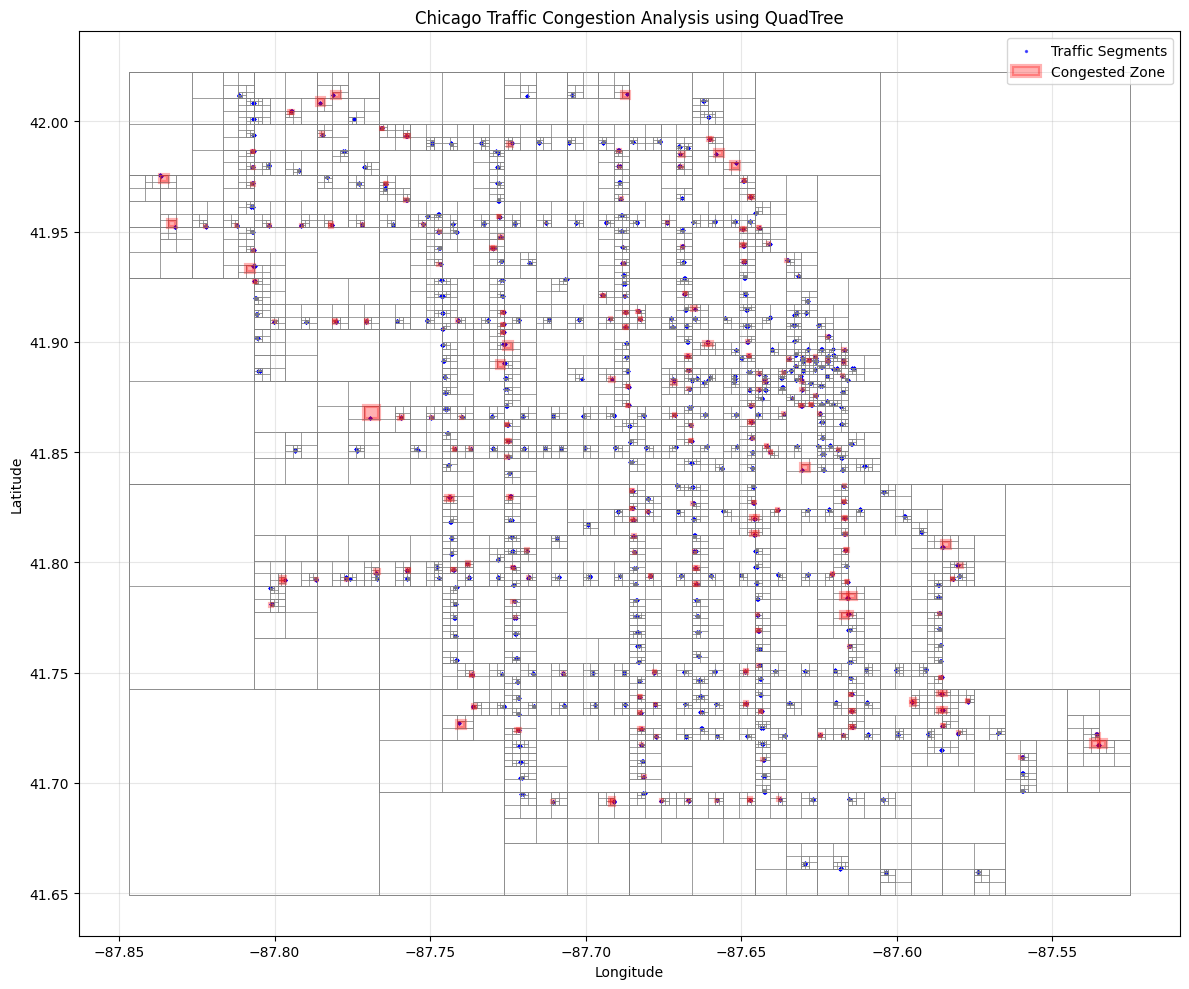

In [34]:
plt.figure(figsize=(12, 10))
# Plot all traffic points
x_coords = [p.x for p in points]
y_coords = [p.y for p in points]
plt.scatter(x_coords, y_coords, c='blue', s=2, alpha=0.6, label='Traffic Segments')

# Draw all QuadTree boundaries
for boundary in all_boundaries:
    rect = patches.Rectangle((boundary.x, boundary.y),
                             boundary.width, boundary.height,
                             linewidth=0.5, edgecolor='gray',
                             facecolor='none', alpha=0.7)
    plt.gca().add_patch(rect)

# Highlight congested zones in red
for i, zone in enumerate(congested_zones):
    b = zone.boundary
    rect = patches.Rectangle((b.x, b.y), b.width, b.height,
                             linewidth=3, edgecolor='red',
                             facecolor='red', alpha=0.3,
                             label='Congested Zone' if i == 0 else "")
    plt.gca().add_patch(rect)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Chicago Traffic Congestion Analysis using QuadTree')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [35]:
print(f"Total traffic segments analyzed: {len(points)}")
print(f"Total QuadTree nodes created: {len(all_boundaries)}")
print(f"Congested zones identified: {len(congested_zones)}")
total_congested_segments = sum(len(zone.points) for zone in congested_zones)
print(f"Traffic segments in congested zones: {total_congested_segments}")
if len(points) > 0:
percentage = (total_congested_segments / len(points)) * 100
print(f"Percentage in congested areas: {percentage:.1f}%")

IndentationError: expected an indented block after 'if' statement on line 6 (ipython-input-1637815474.py, line 7)